# Model: Random Forest Classifier

## Objective:
Our goal is to predict the **road condition type** based on the vehicle sensor readings.
Specifically, we are interested in classifying whether the vehicle is on:
- Asphalt
- Cobblestone
- Dirt Road

We will be using the **cleaned dataset** prepared from `01_data_cleaning.ipynb`.

## Dataset:
- Path: `dataset/cleaned_master_dataset.csv`
- Shape: 1,080,905 rows, 81 columns (after cleaning)

## Tasks Overview:
- Load the cleaned dataset
- Basic data exploration (optional, feel free to plot if needed)
- Select key features for training
- Train **Random Forest Classifier**
- Evaluate performance (Accuracy, Confusion Matrix, etc.)

In [35]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Load the cleaned master dataset
# df = pd.read_csv('/content/cleaned_master_dataset.csv')
df = pd.read_csv('dataset/cleaned_master_dataset.csv')

# Quick check
print(df.shape)
print(df.head())

(1080905, 81)
      timestamp  acc_x_dashboard_left  acc_y_dashboard_left  \
0  1.577219e+09              0.365116              0.167893   
1  1.577219e+09              0.392649              0.176273   
2  1.577219e+09              0.409408              0.181062   
3  1.577219e+09              0.371101              0.164302   
4  1.577219e+09              0.390255              0.159514   

   acc_z_dashboard_left  acc_x_above_suspension_left  \
0              9.793961                     0.327626   
1              9.771216                     0.381496   
2              9.732909                     0.283333   
3              9.749668                     0.314458   
4              9.869378                     0.344385   

   acc_y_above_suspension_left  acc_z_above_suspension_left  \
0                     0.172733                     9.781861   
1                     0.189492                     9.699261   
2                     0.182310                     9.807000   
3                 

In [39]:
# print(f"Total number of columns: {len(df.columns)}")

# for col in df.columns:
#     print(col)

In [ ]:
# Identify and remove rows with NaN values in 'dirt_road'
# print(f"Number of NaNs before dropping: {df['dirt_road'].isnull().sum()}")
# df = df.dropna(subset=['dirt_road'])
# print(f"Number of NaNs after dropping: {df['dirt_road'].isnull().sum()}")

Number of NaNs before dropping: 0
Number of NaNs after dropping: 0


## Exploratory Data Analysis
 The below plot shows the Dashboard left acceleration and right acceleration

## Train the model using RandomForest Classification to predict the road type

In [49]:
# Define features (aligning with LSTM & GRU models)
features = df[[
    'acc_x_dashboard_left', 'acc_y_dashboard_left', 'acc_z_dashboard_left',
    'acc_x_dashboard_right', 'acc_y_dashboard_right', 'acc_z_dashboard_right',
    'gyro_x_dashboard_left', 'gyro_y_dashboard_left', 'gyro_z_dashboard_left'
]]

# Define target variable (multi-class classification)
target = df[['asphalt_road', 'cobblestone_road', 'dirt_road']].idxmax(axis=1)  # Convert one-hot to class labels

# ✅ Convert target class labels to numerical values
target_mapping = {"asphalt_road": 0, "cobblestone_road": 1, "dirt_road": 2}
target = target.map(target_mapping)

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [50]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     93398
           1       0.63      0.66      0.64     62788
           2       0.60      0.51      0.55     59995

    accuracy                           0.74    216181
   macro avg       0.70      0.70      0.70    216181
weighted avg       0.73      0.74      0.73    216181



## 🔍 Feature Engineering & Data Transformation

#### To improve the performance of our Random Forest model, we applied feature engineering techniques to extract meaningful patterns from sensor data. This included:
- Aggregating vibration & gyroscope data to capture magnitude and movement patterns.
- Rolling window transformations to smooth sensor readings and enhance trend detection.
- Creating derived features such as acceleration magnitude and mean absolute deviation.

In [51]:
# Placeholder: Simulating dataset with required columns (replace with actual dataset loading)

np.random.seed(42)

df_engineered = df.copy()  # ✅ Preserve the original dataset
df_engineered = pd.DataFrame({
    "acc_x_dashboard_left": np.random.randn(1000),
    "acc_y_dashboard_left": np.random.randn(1000),
    "acc_z_dashboard_left": np.random.randn(1000),
    "gyro_x_dashboard_left": np.random.randn(1000),
    "gyro_y_dashboard_left": np.random.randn(1000),
    "gyro_z_dashboard_left": np.random.randn(1000)
})

# Define rolling window size (5s window, assuming data collected at fixed intervals)
rolling_window = 5

# Compute acceleration magnitude
df_engineered["acc_magnitude"] = np.sqrt(df_engineered["acc_x_dashboard_left"]**2 + df_engineered["acc_y_dashboard_left"]**2 + df_engineered["acc_z_dashboard_left"]**2)

# Compute gyroscope magnitude
df_engineered["gyro_magnitude"] = np.sqrt(df_engineered["gyro_x_dashboard_left"]**2 + df_engineered["gyro_y_dashboard_left"]**2 + df_engineered["gyro_z_dashboard_left"]**2)

# Apply rolling statistics for vibration (acceleration) and gyroscope data
for col in ["acc_x_dashboard_left", "acc_y_dashboard_left", "acc_z_dashboard_left",
            "gyro_x_dashboard_left", "gyro_y_dashboard_left", "gyro_z_dashboard_left",
            "acc_magnitude", "gyro_magnitude"]:
    
    df_engineered[f"{col}_mean"] = df_engineered[col].rolling(rolling_window).mean()
    df_engineered[f"{col}_std"] = df_engineered[col].rolling(rolling_window).std()
    df_engineered[f"{col}_min"] = df_engineered[col].rolling(rolling_window).min()
    df_engineered[f"{col}_max"] = df_engineered[col].rolling(rolling_window).max()

# Drop raw time-series columns since we are using aggregated features
df_engineered = df_engineered.drop(columns=["acc_x_dashboard_left", "acc_y_dashboard_left", "acc_z_dashboard_left",
                                            "gyro_x_dashboard_left", "gyro_y_dashboard_left", "gyro_z_dashboard_left"])

# Drop rows with NaN values from rolling computations
df_engineered = df_engineered.dropna().reset_index(drop=True)

print(df_engineered.head())


   acc_magnitude  gyro_magnitude  acc_x_dashboard_left_mean  \
0       2.031778        1.647754                   0.459003   
1       0.505119        1.938637                   0.312833   
2       1.815292        2.940966                   0.656328   
3       1.288423        1.740353                   0.680277   
4       1.325357        1.396327                   0.281777   

   acc_x_dashboard_left_std  acc_x_dashboard_left_min  \
0                  0.708232                 -0.234153   
1                  0.771130                 -0.234153   
2                  0.892867                 -0.234153   
3                  0.894183                 -0.234153   
4                  0.868322                 -0.469474   

   acc_x_dashboard_left_max  acc_y_dashboard_left_mean  \
0                  1.523030                   0.486981   
1                  1.523030                   0.285807   
2                  1.579213                   0.279919   
3                  1.579213                   

## ⚖️ Handling Class Imbalance with Class Weights

To ensure our Random Forest model does not favor majority classes, we apply class weights. This method adjusts the model’s learning process by giving more importance to underrepresented classes. The weights are computed based on class distribution and incorporated into the model before hyperparameter tuning.

In [52]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ✅ Define target columns
target_columns = ['asphalt_road', 'cobblestone_road', 'dirt_road']

# ✅ Convert target class labels to numerical values
target_mapping = {"asphalt_road": 0, "cobblestone_road": 1, "dirt_road": 2}
target = target.map(target_mapping)

# ✅ Features: Use the engineered dataset
features = df_engineered

# ✅ Target: Convert multi-label (one-hot) encoding to categorical labels
target = df[target_columns].idxmax(axis=1)  # Converts one-hot to categorical

# ✅ Compute class weights for multi-class classification
class_weight_dict = {}

# Convert categorical labels to numerical indices (0,1,2)
target_numeric = target.astype('category').cat.codes  

# Compute class weights
# class_weights = compute_class_weight('balanced', classes=np.unique(target_numeric), y=target_numeric)
class_weights = compute_class_weight('balanced', classes=np.unique(target), y=target)

# ✅ Convert to dictionary (Mapping: {class_index: weight})
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# ✅ Display computed weights
print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0: 0.7709675601689288, 1: 1.1466432013782144, 2: 1.2036334886724904}


In [53]:
from sklearn.ensemble import RandomForestClassifier

# ✅ Train Random Forest with class weights
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
rf_model.fit(X_train, y_train)

# ✅ Predictions
y_pred = rf_model.predict(X_test)

# ✅ Classification Report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     93398
           1       0.63      0.66      0.64     62788
           2       0.60      0.52      0.56     59995

    accuracy                           0.74    216181
   macro avg       0.70      0.70      0.70    216181
weighted avg       0.73      0.74      0.73    216181



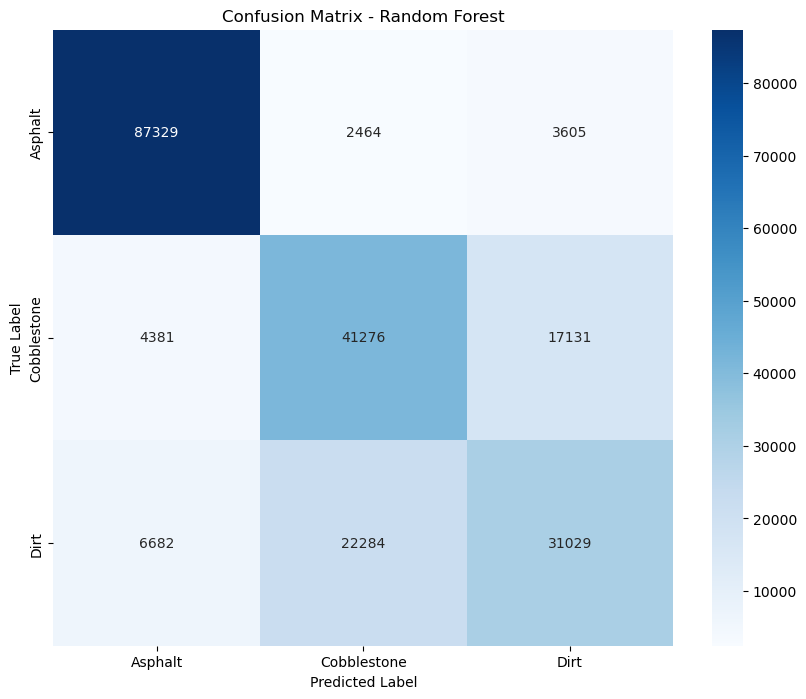

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Asphalt", "Cobblestone", "Dirt"], yticklabels=["Asphalt", "Cobblestone", "Dirt"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


### 🔍 Confusion Matrix Insights
- The confusion matrix confirms that asphalt roads are classified correctly most of the time.
- However, cobblestone and dirt roads have significant misclassifications, indicating the need for further feature engineering or tuning.
- The model has higher false positives when predicting dirt roads, which affects the overall recall for this class.

Text(0.5, 1.0, 'Top 10 Important Features - Random Forest')

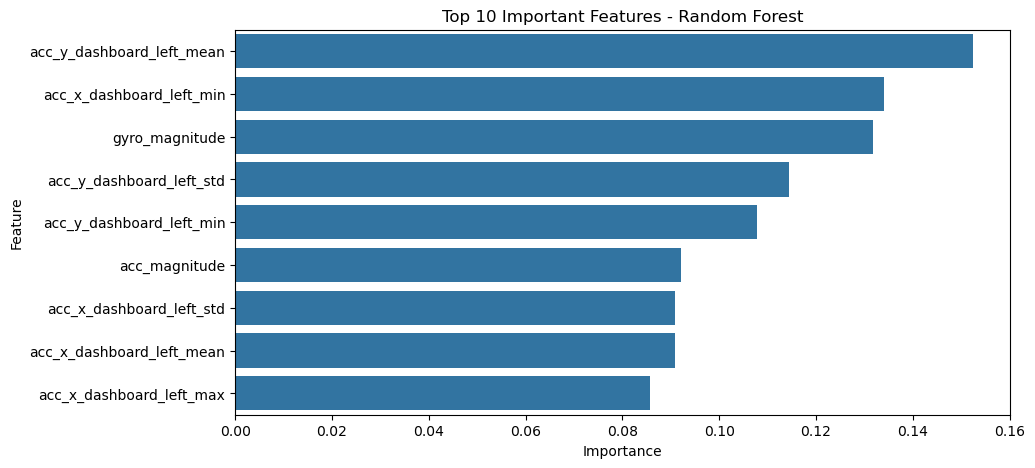

In [57]:
# ✅ Feature Importance Plot
importances = rf_model.feature_importances_

# Get the feature names from the original DataFrame before scaling
feature_names = df_engineered.columns  # Make sure df_engineered is the DataFrame before scaling

sorted_indices = np.argsort(importances)[::-1][:10]  # Top 10 features
plt.figure(figsize=(10, 5))
sns.barplot(x=importances[sorted_indices], y=[feature_names[i] for i in sorted_indices])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Important Features - Random Forest")

### 🔥 Feature Importance Analysis

The most influential features for road classification include:
- Acceleration metrics (acc_y_dashboard_left_mean, acc_x_dashboard_left_min)
- Gyroscope magnitude (gyro_magnitude)
- Acceleration magnitude (acc_magnitude)
 
**These insights suggest that vibrational and gyroscope data play a key role in predicting road conditions.**

## Save the model to disk

In [ ]:
# save the model
import pickle

# Save the model to a file
with open('/content/random_forest_model.pkl', 'wb') as f:
    pickle.dump(model, f)
